이번 과제는 Bert Model을 사용하여 BBC 뉴스 기사의 category를 분류해보는 과제입니다. clone coding을 하시되, 코드 주석을 line by line으로 꼼꼼하게 달아보시며 공부해보세요!

## 데이터 로드 및 탐색

In [1]:
%%capture
!pip install transformers

In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/KUBIG 24-w/week4/bbc-text.csv')

In [5]:
df.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [6]:
print(len(df))

2225


In [7]:
df.groupby('category').count()

,text
category,
business,510
entertainment,386
politics,417
sport,511
tech,401


## BertTokenizer

토크나이저로 pretrain된 BERT의 BertTokenizer를 갖고 옵니다. 여러 종류를 시도해보세요.

- bert-base-uncased : 108MB param, all lowercase
- bert-large-cased : 340MB param, both upper and lower
- bert-base-cased : 108MB param, multi language, both upper and lower


uncased는 accent markers도 없애줌 -> Named Entity Recognition, Part-of-Speech tagging의 경우 cased가 더 낫고 이를 제외한 대부분은 uncased 사용하는 것이 더 낫다고 함

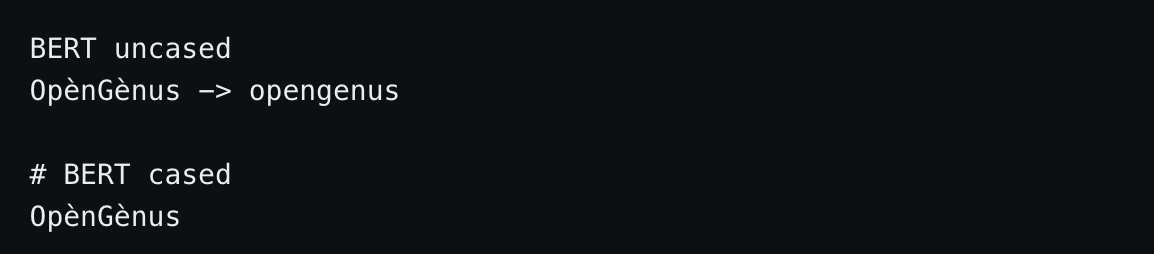

In [8]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'business':0,
          'entertainment':1,
          'sport':2,
          'tech':3,
          'politics':4
          } #각각 레이블에 해당하는 정수 매핑해주는 Dictionary

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

## Dataset

In [9]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):
        self.labels = [labels[label] for label in df['category']]
        self.texts = [tokenizer(text,
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text']]
                                #truncation=True : 시퀀스가 최대 길이를 초과하는 경우 자름

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

## Train & Evaluate BertClassifier

pretrain된 BertModel을 불러옵니다. 다른 간단한 층들도 같이 쌓아줍니다.

- bert-base-cased: 12-layer, 768-hidden, 12-self attention heads, 110M parameters. Trained on cased English text.


다른 종류들의 pretrianed model은 아래 링크에서 확인할 수 있습니다.

https://huggingface.co/transformers/v2.9.1/pretrained_models.html

In [11]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased') #out_features=768
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 5)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [13]:
model = BertModel.from_pretrained('bert-base-cased')
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(28996, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

`attention_mask`, `input_ids` -> BERT 토크나이저를 사용하여 텍스트를 토큰화하고 인코딩할 때 생성되는 요소들

- `input_ids`: 입력 텍스트를 토큰화하여 각 토큰을 고유한 정수로 변환한 결과, BERT 모델의 입력으로 사용되는 정수 시퀀스

- `attention_mask`: BERT 모델은 입력 시퀀스의 각 토큰에 대한 attention을 계산함. 이때, 패딩된 토큰은 실제 입력값이 아니므로 attention을 수행할 필요가 없으므로, 패딩된 토큰의 위치 나타냄. Mask values selected in [0, 1]

train_input은 토크나이저를 사용하여 텍스트를 처리한 결과로, 각각의 요소들이 딕셔너리 형태로 저장되어 있음

https://bo-10000.tistory.com/132

In [14]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device) #[0, 1] / 패딩된 부분 0, 아닌 부분 1
                input_id = train_input['input_ids'].squeeze(1).to(device) #정수 시퀀스

                output = model(input_id, mask)

                batch_loss = criterion(output, train_label.long()) #long : 64비트 정수형 데이터
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad(): #gradient 계산 x

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label.long())
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc

            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')


In [15]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc

    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [16]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42),
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

1780 222 223


In [17]:
EPOCHS = 2 #EPOCH 수 늘려보기!
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 890/890 [03:02<00:00,  4.88it/s]


Epochs: 1 | Train Loss:  0.732 | Train Accuracy:  0.394 | Val Loss:  0.552 | Val Accuracy:  0.640


100%|██████████| 890/890 [03:12<00:00,  4.63it/s]


Epochs: 2 | Train Loss:  0.383 | Train Accuracy:  0.832 | Val Loss:  0.233 | Val Accuracy:  0.955


In [18]:
evaluate(model, df_test)

Test Accuracy:  0.964


In [19]:
EPOCHS = 5 #EPOCH 수 늘려보기!
model = BertClassifier()
LR = 1e-6

train(model, df_train, df_val, LR, EPOCHS)

100%|██████████| 890/890 [03:12<00:00,  4.63it/s]


Epochs: 1 | Train Loss:  0.785 | Train Accuracy:  0.293 | Val Loss:  0.662 | Val Accuracy:  0.568


100%|██████████| 890/890 [03:11<00:00,  4.65it/s]


Epochs: 2 | Train Loss:  0.465 | Train Accuracy:  0.749 | Val Loss:  0.263 | Val Accuracy:  0.937


100%|██████████| 890/890 [03:11<00:00,  4.64it/s]


Epochs: 3 | Train Loss:  0.191 | Train Accuracy:  0.953 | Val Loss:  0.118 | Val Accuracy:  0.986


100%|██████████| 890/890 [03:11<00:00,  4.65it/s]


Epochs: 4 | Train Loss:  0.090 | Train Accuracy:  0.987 | Val Loss:  0.061 | Val Accuracy:  0.995


100%|██████████| 890/890 [03:11<00:00,  4.65it/s]


Epochs: 5 | Train Loss:  0.050 | Train Accuracy:  0.993 | Val Loss:  0.043 | Val Accuracy:  0.991


In [20]:
evaluate(model, df_test)

Test Accuracy:  0.991
